In [54]:
import re,os
import json
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid")

In [55]:
data = pd.read_csv('data/PoetryFoundationData.csv',header=0)
data.head()

,Unnamed: 0,Title,Poem,Poet,Tags
0,0,\r\r\n Objects Used to Prop...,"\r\r\nDog bone, stapler,\r\r\ncribbage board, ...",Michelle Menting,NaN
1,1,\r\r\n The New Church\r\r\n...,"\r\r\nThe old cupola glinted above the clouds,...",Lucia Cherciu,NaN
2,2,\r\r\n Look for Me\r\r\n ...,\r\r\nLook for me under the hood\r\r\nof that ...,Ted Kooser,NaN
3,3,\r\r\n Wild Life\r\r\n ...,"\r\r\nBehind the silo, the Mother Rabbit\r\r\n...",Grace Cavalieri,NaN
4,4,\r\r\n Umbrella\r\r\n ...,\r\r\nWhen I push your button\r\r\nyou fly off...,Connie Wanek,NaN


In [56]:
data.isna().sum(axis = 0)

Unnamed: 0      0
Title           0
Poem            0
Poet            0
Tags          955
dtype: int64

## Dataset cleaning
Save poems and its corresponding label in separate files

In [109]:
def pre_process(text):
    text = text.lower()
    text = text.replace("\r", "").strip('\n').strip()
    text = re.sub('\n+', '\n',text)
    text = text.replace("\n ", "")
    text = text.replace("\n", " <eos> ")
    text = re.sub(' +', ' ',text)
    return text

def pre_process_tags(tags):
    tags = tags.lower()
    tags = tags.split(",")
    tags = [x.strip() for x in tags]
    return tags

def unique_tags(tags):
    tag_freq = {}
    for tag in tags:
        items = tag.split(",")
        for item in items:
            item = item.lower().strip()
            if item in tag_freq:
                tag_freq[item] += 1
            else:
                if item !="":
                    tag_freq[item] = 1
    
    return dict(sorted(tag_freq.items(),key=operator.itemgetter(1),reverse=True))


poems = data["Poem"].to_numpy()
tags = data["Tags"].fillna("").to_numpy()
out_dir = "data/poetry-foundation"
os.makedirs(out_dir, exist_ok=True)

# Extract poems
with open(out_dir+'/poems.txt', 'w') as f:
    for poem in poems:
        f.write(pre_process(poem)+'\n')

# Extract corresponding tags
with open(out_dir+'/tags.txt', 'w') as f:
    for tag in tags:
        tag_list = pre_process_tags(tag)
        f.write(",".join(tag_list) +'\n')

# Extract list of unique tags
with open(out_dir+'/uniq_tags.txt', 'w') as f:
    tag_freq = unique_tags(tags)
    for tag, freq in tag_freq.items():
        f.write(tag+"\t"+str(freq)+"\n")


## Create mapping 
In total there are 129 unique tags that these poems have. Get rid of uncommon ones.

In [5]:
# TODO

Create tags to integer representation mapping and save it as json.

In [110]:
tag2int = { tag: intid+1  for intid, tag in enumerate(list(tag_freq.keys())) }
with open(out_dir+'/tag2int.json', 'w') as fp:
    json.dump(tag2int, fp)

# create int_tags.txt which is an integer representation of tags of all poems.
with open(out_dir+'/tag2int.json') as fp:
    tag2int = json.load(fp)

def tag_mapper(tags):
    int_tags = []
    for i in tags:
        int_tags.append(tag2int[i])
    return int_tags

labels_int = []
with open(out_dir+'/tags.txt') as fp:
    for line in fp:
        tags = line.rstrip().split(",")
        if tags[0] !='':
            labels_int.append(tuple(tag_mapper(tags)))
        else:
            labels_int.append(tuple([-1]))

## Data prepration

In [111]:
## Data preparation: list of tagged Poems
with open(out_dir+'/poems.txt') as fp:
    all_poems = [poem.strip() for poem in fp]

In [112]:
all_poems[0]

"dog bone, stapler, <eos> cribbage board, garlic press because this window is loose—lacks <eos> suction, lacks grip. <eos> bungee cord, bootstrap, <eos> dog leash, leather belt because this window had sash cords. <eos> they frayed. they broke. <eos> feather duster, thatch of straw, empty <eos> bottle of elmer's glue because this window is loud—its hinges clack <eos> open, clack shut. <eos> stuffed bear, baby blanket, <eos> single crib newel because this window is split. it's dividing <eos> in two. <eos> velvet moss, sagebrush, <eos> willow branch, robin's wing because this window, it's pane-less. it's only <eos> a frame of air."

## Feature extraction

In [113]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer


t_words = Tokenizer()
t_words.fit_on_texts(all_poems)  
X = t_words.texts_to_sequences(all_poems)
X = pad_sequences(X, maxlen=100, truncating='post')

X_lab, y = [],[]
X_unlab = []
for i in range(len(labels_int)):
    if labels_int[i][0] != -1:
        y.append(tuple(labels_int[i]))
        X_lab.append(X[i])
    else:
        X_unlab.append(X[i])
vocabulary = t_words.word_index

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

In [114]:
X_lab[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,  1185,   545,  1613,
          32,   882,   635,    58,  6081,    34,   571,     4,   537,
          34,   129,  1147,   539,   349,     2,   545,    54,   736,
           6,   304,    56,  3809,    54,   101,  6417,     3,  1250,
         395,    15,     2,   612,   336,    56,   455,   166,   455,
           2,   635,   452,    54,    33, 25659,    34,  9640,  3898,
        1880,     2, 56910, 56911,    48,    35,   298,     6,     2,
         967], dtype=int32)

In [116]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
import io
from torchtext.vocab import Vocab


en_tokenizer = get_tokenizer('spacy', language='en')

def build_vocab(filepath, tokenizer):
    counter = Counter()
    with io.open(filepath, encoding="utf8") as f:
        for string_ in f:
            counter.update(tokenizer(string_))
    return Vocab(counter, specials=['<eos>'])

en_vocab = build_vocab(out_dir+'/poems.txt', en_tokenizer)

In [98]:
def data_process(filepath):
    raw_en_iter = iter(io.open(filepath, encoding="utf8"))
    data = []
    for raw_en in raw_en_iter:
        en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en)],
                                  dtype=torch.long)
        data.append(en_tensor_)
    return data
train_data = data_process(out_dir+'/poems.txt')

In [108]:
train_data[4]

tensor([   54,    12,  1732,    49,  2888,     2,     3,     1,    16,   597,
          145,     5,  2731,     4,     2,     3,     1,   114,   404,     7,
          549,     4,     2,     3,     1,   151,  3112,   891,     6,     2,
            3,     1,    31,   869,  2330,     4,    16,     7,  1598,     2,
            3,     1,   309,     8,    82,     2,     3,     1,  6071,    17,
          181,     4,     2,     3,     1,    53,  1378,    11,    35, 55347,
            2,     3,     1,    20,  9501,     8,     2,     3,     1,     5,
          289,  6195,   280,     2,     3,     1,    59,   734,   826,    23,
          180,     2,     3,     1,    11,    42,  3293,     6,     2,     3,
            1,   188,     9, 45265,    57,     2,     3,     1,   359,    14,
         5363,     2,     3,     1,    33,    17,   967,     2,     3,     1,
          125,    10,   239,     9,   388,     6,     2,     3,     1,    32,
           54,     5,   185,    15,    36,     2,     3,     1, 

### Correlation among poems labels
Plot relation among top 10 frequent tags

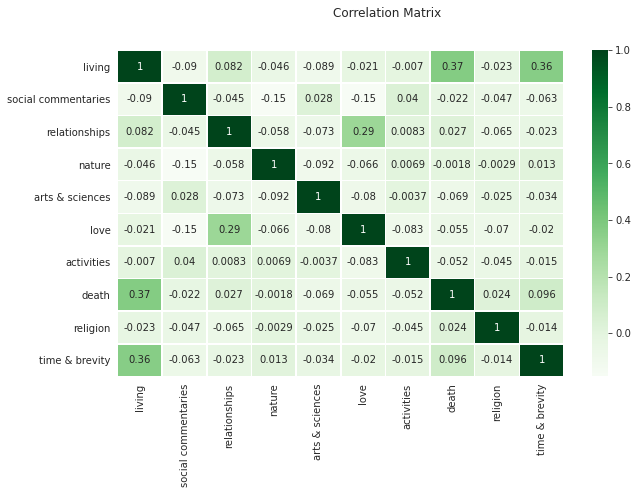

In [36]:
train = pd.DataFrame(y[:,:10], columns=list(tag_freq.keys())[:10])
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Correlation Matrix')
sns.heatmap(train.corr(), annot=True, cmap="Greens", linewidths=.5, ax=ax);

The correlation figure shows that categories like `living` and `time & brevity`; `living` and `death`; `relationship` and `love` are highly correlated which makes perfect sense

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_lab, y, shuffle=True,
                                                    test_size=0.2,random_state=123) 
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, 
                                                                shuffle=True, test_size=0.25,random_state=123)

### USING PRE-TRAINED EMBEDDING (GLOVE)
Load pre-trained glove embeddings(100 dimension)

In [119]:
## Download glove embeddings
# !wget https://nlp.stanford.edu/data/glove.6B.zip
glove_file = open('glove/glove.6B.100d.txt', encoding="utf8")
embeddings_index = dict()
for line in glove_file:
    val = line.split(' ')
    word = val[0]
    coefs = np.asarray(val[1:]).astype(float)
    embeddings_index[word] = coefs
glove_file.close()

print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix
embedding_matrix = np.zeros((len(vocabulary)+1, 100))

for word, i in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


In [12]:
word2idx = vocabulary
idx2word = {v: k for k, v in vocabulary.items()}

In [145]:
import pickle 
np.save('glove/glove.6B.100d.npy',embedding_matrix)
with open('glove/glove.6B.100d_word2idx.pkl', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('glove/glove.6B.100d_idx2word.pkl', 'wb') as handle:
    pickle.dump(idx2word, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Define Model: Bi-directional LSTM


In [195]:
import torch.nn as nn

class BiRNN(nn.Module):    
    def __init__(self, embedding_weights, hidden_dim, 
                 output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        vocab_size, embedding_dim = embedding_weights.shape
        self.seq_lengths = embedding_weights.shape[1]
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # convert sparse 1 hot encoded vectors to embeddings (glove embedding will be used here)
#         self.embedding.load_state_dict({'weight': embedding_weights})
        self.embedding.weight.data.copy_(torch.FloatTensor(embedding_weights))
        self.embedding.weight.requires_grad = False
        
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers = n_layers, 
                           bidirectional = bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        out, hidden = self.rnn(embedded)
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        output = torch.cat([out[i,self.seq_lengths[i]-1,:].unsqueeze(0) for i in range(out.shape[0])])
        output = self.linear(output)
        return output
    
#         hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
#         return self.fc(hidden.squeeze(0))



In [196]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision.transforms import ToTensor, Lambda

class DatasetMaper(Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    
class Run:
    '''Training, evaluation and metrics calculation'''

    @staticmethod
    def train(model, data):
        
        train = DatasetMaper(data['x_train'], data['y_train'])
        test = DatasetMaper(data['x_test'], data['y_test'])
        valid = DatasetMaper(data['x_valid'], data['y_valid'])
        
        # Define params
        batch_size = 32
        save_model = True
        epochs = 10
        learning_rate = 0.0005
        out_dir = "lstm-model"
        
        # Initialize loaders
        loader_train = DataLoader(dataset=train,
                                 batch_size=batch_size,
                                 shuffle=True)
        loader_valid = DataLoader(dataset=valid,
                                  batch_size=batch_size,
                                  shuffle=False)
        
        loader_test = DataLoader(dataset=test,
                                 batch_size=batch_size,
                                 shuffle=False)
        
        

        # Define optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss(reduction='none')

        # Tracking best validation accuracy
        best_accuracy = 0
        
        print("\nStart training...")
        # print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Train Acc':^10} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Train Acc':^10} | {'Val Loss':^10} | {'Val Acc':^9} | {'Test Acc':^9} | {'Elapsed':^9}")
        print("-"*80)
    
        # Starts training phase
        train_loss_list = []
        val_loss_list = []
        test_acc_list = []
        
        for epoch in range(epochs):
            # =======================================
            #               Training
            # =======================================

            # Tracking time and loss
            t0_epoch = time.time()
            total_loss = 0
            train_accuracy = 0

            # Put the model into training mode
            model.train()
        
            # Starts batch training
            for x_batch, y_batch in loader_train:
                # Load batch to GPU
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                

                # Feed the model
#                 import pdb; pdb.set_trace()
                y_pred = model(x_batch.long())

                # Compute loss and accumulate the loss values
                loss = criterion(y_pred, y_batch)
                total_loss += loss.item()

                # Clean gradients
                optimizer.zero_grad()

                # Gradients calculation
                loss.backward()

                # Gradients update
                optimizer.step()
            
                # Training metrics (for one batch)
                corrects = (torch.max(y_pred, 1)[1].view(y_batch.size()).data == y_batch.data).sum()
                acc = 100.0 * corrects_adv/loader_train.batch_size
                train_accuracy += acc
                

            # Calculate the average loss over the entire training data for a batch
            avg_train_loss = total_loss / len(loader_train)
            train_loss_list.append(avg_train_loss)
            
            # Compute accuracy averaged over all batches for an epoch
            train_accuracy = train_accuracy / len(loader_train)
            
            # =======================================
            #               Evaluation
            # =======================================
            
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            
            # Training metrics
            corrects = (torch.max(y_pred, 1)[1].view(y_batch.size()).data == y_batch.data).sum()
            train_accuracy = 100.0 * corrects/loader_train.batch_size
            
            
            # Validation metrics
            val_loss, val_accuracy = evaluation(model, loader_valid)
            _, test_accuracy = evaluation(model, loader_test)
            val_loss_list.append(val_loss)
            test_acc_list.append(test_accuracy)
            
            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                # Save the best model
                os.makedirs(params.out_dir, exist_ok=True)
                if params.save_model:
                    # Also keeping the best model with one name to make it easy to load it later
                    PATH = params.out_dir + "/bi-dir_lstm_" + str(epoch+1) +"_batch_size_" + str(params.batch_size) + ".pth"
                    torch.save(model.state_dict(), PATH)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch + 1:^7} | {avg_train_loss:^12.6f} | {train_accuracy:^10.2f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {test_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
            
        print("\n")
        print(f"Training complete! \nBest accuracy: {best_accuracy:.2f} %.")
        return train_loss_list, val_loss_list, test_acc_list


def evaluation(model, loader_valid):

    # Set the model in evaluation mode

    model.eval()
    corrects, avg_loss = 0, 0
    criterion = nn.CrossEntropyLoss(reduction='none')
    # Start evaluation phase   
    with torch.no_grad():
        for x_batch, y_batch in loader_valid:
            x_batch = x_batch.to(DEVICE); 
            y_batch = y_batch.to(DEVICE)
            
            y_pred = model(x_batch.long())
            
            loss = criterion(y_pred, y_batch)
            
            avg_loss += loss.item()
            corrects += (torch.max(y_pred, 1) [1].view(y_batch.size()).data == y_batch.data).sum()
            
    size = len(loader_valid.dataset)
    avg_loss /= size
    accuracy = 100.0 * corrects/size
    
    return avg_loss, accuracy

In [197]:
import time
import torch

data = {
    'x_train': X_train,
    'y_train': y_train,
    'x_test': X_test,
    'y_test': y_test,
    'x_valid': X_validation,
    'y_valid': y_validation
        }

input_dim = embedding_matrix.shape[0]

embedding_dim = embedding_matrix.shape[1]
hidden_dim = 1024
output_dim = embedding_matrix.shape[1]

n_layers = 3 # for mutil layer rnn
bidirectional = True

dropout = 0.3

# DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
DEVICE = 'cpu'
# Initialize the model
start = time.time()
model = BiRNN(embedding_matrix, 
              hidden_dim, 
              output_dim, 
              n_layers, 
              bidirectional, 
              dropout)
model.to(DEVICE)
# print(model)

# Train and Evaluate the pipeline
train_loss_list, val_loss_list, test_acc_list, PATH = Run().train(model, data)
end = time.time()
print("*** Training Complete ***")
print("Training runtime: {:.2f} s".format(end-start))


Start training...
 Epoch  |  Train Loss  | Train Acc  |  Val Loss  |  Val Acc  | Test Acc  |  Elapsed 
--------------------------------------------------------------------------------


AttributeError: 'Tensor' object has no attribute 'batch_sizes'

In [16]:
## define parameters

config = {
    "n_iters": 40000,
    "batch_size" : 64,
    "learning_rate" : 0.0005,
    "max_num_lines" : 8,
    "Word_LSTM" : {
        "embedding_size" : 100,
        "hidden_size" : 1024,
        "num_layers" : 3,
        "bidirectional" : True
    }

In [37]:
import torch.nn as nn
import torch

class WordLSTM(nn.Module):
    def __init__(self, output_size, config, device):
        super(WordLSTM, self).__init__()
        embedding_size = config['Word_LSTM']['embedding_size']
        self.hidden_size = config['Word_LSTM']['hidden_size']
        self.batch_size = config['batch_size']
        self.num_layers = config['Word_LSTM']['num_layers']
        self.bidirectional = config['Word_LSTM']['bidirectional']

        lstm_input_size = embedding_size

        self.device = device

        self.lstm = nn.LSTM(lstm_input_size, self.hidden_size, num_layers=self.num_layers,
                            bidirectional=self.bidirectional, batch_first=True, dropout=0.3)

        self.linear = nn.Linear(self.hidden_size, output_size)


    def init_hidden(self, batch_size = None):
        if batch_size is None:
            batch_size = self.batch_size
        if self.bidirectional:
            return (torch.zeros(self.num_layers*2, batch_size, self.hidden_size).to(self.device),
                    torch.zeros(self.num_layers*2, batch_size, self.hidden_size).to(self.device))
        else:
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device),
                    torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device))


    def forward(self, input_tensor, hidden, seq_lengths):
        input_tensor = torch.nn.utils.rnn.pack_padded_sequence(input_tensor, seq_lengths, batch_first=True)
        out, hidden = self.lstm(input_tensor, hidden)
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        output = torch.cat([out[i, seq_lengths[i] - 1, :].unsqueeze(0) for i in range(out.shape[0])])
        output = self.linear(output)
        return output, hidden

In [38]:
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
output_size = embedding_matrix.shape[1]
model = WordLSTM(output_size, config, DEVICE)

In [39]:
import matplotlib
import argparse
import json
import datetime
import logging

import time
import math

matplotlib.use('Agg')

import matplotlib.pyplot as plt
import sys

try:
    from apex.parallel import DistributedDatanParallel as DDP
    from apex.fp16_utils import *
    from apex import amp, optimizers
    from apex.multi_tensor_apply import multi_tensor_applier
    use_apex = True

except ImportError:
    use_apex = False

use_apex = False

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

class Trainer:
    def __init__(self, input_size, output_size, config, model, type):
        self.device = torch.device("cuda" if (torch.cuda.is_available() and config['GPU']) else "cpu")

        self.loadGlove(config['use_reduced_glove'])
        self.max_num_lines = config['max_num_lines']

        if model == "homogeneous":
            if type == "char":
                self.model = CharLSTM(input_size, output_size, config, self.device)
            elif type == "word":
                self.model = WordLSTM(output_size, config, self.device)


        self.criterion = nn.CrossEntropyLoss(reduction='none')
        self.model = self.model.to(self.device)
        self.optim = torch.optim.Adam(self.model.parameters(), lr=config['learning_rate'])
        if use_apex:
            self.model, self.optim = amp.initialize(self.model, self.optim, opt_level="O1")

    def loadGlove(self, use_reduced_glove, glove_size=100):
        if use_reduced_glove:
            glove_dir = "glove"
        else:
            glove_dir = "glove"
        self.glove = np.load("{}/glove.6B.{}d.npy".format(glove_dir, glove_size))
        self.word2idx = pickle.load(open("glove/glove.6B.100d_word2idx.pkl", 'rb'))
        self.idx2word = pickle.load(open("glove/glove.6B.100d_idx2word.pkl", 'rb'))

    def getInputTensor_char(self, line):
        tensor = torch.zeros(1, len(line), dtype=torch.long)
        for li in range(len(line)):
            tensor[0][li] = all_letters.find(line[li])
        return tensor

    def getInputTensor_word(self, line):
        tensor = torch.zeros((1, len(line), self.glove.shape[1]), dtype=torch.float)
        for li in range(len(line)):
            tensor[0][li] = torch.FloatTensor(self.glove[self.word2idx.get(line[li], self.word2idx.get("<UNK>"))])
        return tensor


    def batchOutputTensor(self, topics, topic_list):
        return torch.tensor([topic_list.index(topics[bi]) for bi in range(len(topics))], dtype=torch.long)

    def inputTensor(self, line):
        raise NotImplementedError

    def outputTensor(self, topic, topic_list):
        return torch.tensor([topic_list.index(topic)], dtype=torch.long)

    def batchInputTensor(self, lines):
        raise NotImplementedError

    def train_batch_packed_seq(self, input_tensor, seq_lengths, output_tensor):
        hidden = self.model.init_hidden()
        self.model.zero_grad()

        input_tensor = input_tensor.to(self.device)
        output_tensor = output_tensor.to(self.device)

        output, _ = self.model(input_tensor, hidden, seq_lengths)
        batch_loss = torch.sum(self.criterion(output, output_tensor))
        if use_apex:
            with amp.scale_loss(batch_loss, self.optim) as scaled_loss:
                scaled_loss.backward()
        else:
            batch_loss.backward()
        self.optim.step()

        return batch_loss

    def evaluate(self, input_tensor, seq_lengths, output_tensor):
        with torch.no_grad():
            hidden = self.model.init_hidden()

            input_tensor = input_tensor.to(self.device)
            output_tensor = output_tensor.to(self.device)

            output, _ = self.model(input_tensor, hidden, seq_lengths)

            _, max_indices = torch.max(output, 1)
            train_acc = (max_indices == output_tensor).sum().cpu().data.numpy() / max_indices.size()[0]
            return train_acc

    def load(self, filepath):
        logging.info("Loading model from file {}".format(filepath))
        self.model.load_state_dict(torch.load(filepath, map_location=self.device))
        logging.info("Model loaded successfully !")

    def save(self, filepath):
        logging.info("Saving model to file {}".format(filepath))

        torch.save(self.model.cpu().state_dict(), filepath)
        self.model = self.model.to(self.device)

        logging.info("Model saved successfully !")



class Trainer_Character(Trainer):
    def __init__(self, input_size, output_size, config, model, type):
        Trainer.__init__(self, input_size, output_size, config, model, type)

    def inputTensor(self, line):
        return self.getInputTensor_char(line)

    def batchInputTensor(self, lines):
        tensor = torch.zeros(len(lines), len(lines[0]), dtype=torch.long)
        for bi in range(len(lines)):
            tensor[bi] = self.getInputTensor_char(lines[bi])
        return tensor


class Trainer_Word(Trainer):
    def __init__(self, input_size, output_size, config, model, type):
        Trainer.__init__(self, input_size, output_size, config, model, type)

    def inputTensor(self, line):
        return self.getInputTensor_word(line)

    def batchInputTensor(self, lines):
        tensor = torch.zeros((len(lines), len(lines[0]), self.glove.shape[1]), dtype=torch.float)

        for bi in range(len(lines)):
            tensor[bi] = self.getInputTensor_word(lines[bi])

        return tensor

def train_homogeneous():
    all_losses = []
    all_evaluation_scores = []
    total_loss = 0
    evaluation_scores = []

    early_stopping_mean = 25
    min_evaluation_mean = 100000
    min_iters = 20000

    start = time.time()


    for it in range(1, n_iters + 1):
        if it < n_iters // 2:
            poems, topics, seq_lengths = dataset.getSequentialBatch(batch_size)
        else:
            poems, topics, seq_lengths = dataset.getRandombatch(batch_size)

        input_tensor = trainer.batchInputTensor(poems)

        loss = trainer.train_batch_packed_seq(input_tensor, seq_lengths,
                                              trainer.batchOutputTensor(topics, dataset.topics_list))
        total_loss += loss

        if it % print_every == 0:
            logging.info('%s (%d %d%%) %.4f' % (timeSince(start), it, it / n_iters * 100, loss))

        if it % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0

        if it % evaluate_every == 0:
            poems, topics, seq_lengths = dataset.getTestBatch(batch_size)
            input_tensor = trainer.batchInputTensor(poems)

            evaluation_score = trainer.evaluate(input_tensor, seq_lengths,
                                                trainer.batchOutputTensor(topics, dataset.topics_list))

            all_evaluation_scores.append(evaluation_score)

            if len(evaluation_scores) == early_stopping_mean:
                evaluation_scores = evaluation_scores[1:]
            evaluation_scores.append(evaluation_score)


            evaluation_mean = np.mean(evaluation_scores)

            logging.info("Evaluation Score = {}, Min Evaluation Score Min Mean = {} Evaluation mean score = {} for {} "
                         "samples".format(evaluation_score, min_evaluation_mean, evaluation_mean, len(evaluation_scores)))

            # if evaluation_mean > min_evaluation_mean + 0.1 and it > min_iters:
            #     logging.info("Stopping Training, current evaluation score mean {} is greater than min Evaluation "
            #                  "score of {}".format(evaluation_mean, min_evaluation_mean))
            #     break

            min_evaluation_mean = min(min_evaluation_mean, evaluation_mean)

        if it % save_every == 0:
            plt.figure()
            plt.plot(all_losses)
            plt.savefig('plots/loss_' + dt_now.strftime('%d_%m_%Y_%H_%M_%S'))
            plt.close()
            trainer.save("saved_models/{}_".format(args.filename) + dt_now.strftime('%d_%m_%Y_%H_%M_%S'))

    np.save("results/{}".format('EvaluationScores_' + dt_now.strftime('%d_%m_%Y_%H_%M_%S')), all_evaluation_scores)
    plt.figure()
    plt.plot(all_evaluation_scores)
    plt.savefig('plots/evaluation_' + dt_now.strftime('%d_%m_%Y_%H_%M_%S'))
    plt.close()

    logging.info("Training Over !!!")


In [ ]:
config_file_path = args.config_file

with open(config_file_path,'r') as file:
    config = json.load(file)

# Hyer-Params
n_iters = config['n_iters']
batch_size = config['batch_size']


#Logistic Params
print_every = config['print_every']
evaluate_every = config['evaluate_every']
plot_every = config['plot_every']
save_every = config['save_every']
# in_file_name = config['file_name']
# test_file_name = config['test_file_name']
# validation_file_name = config['validation_file_name']
log_name = config['log_name']

dt_now = datetime.datetime.now()


logging.basicConfig(level=logging.INFO,
    filename= log_name + "_" + args.filename + "_" + dt_now.strftime('%d_%m_%Y_%H_%M_%S.log'),
    filemode='w',
    format='%(name)s - %(levelname)s - %(message)s'
)

if args.print:
    ch = logging.StreamHandler(sys.stdout)
    ch.setLevel(logging.INFO)
    formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
    ch.setFormatter(formatter)
    logging.getLogger().addHandler(ch)

logging.info("Config File used : {}, Config Options : {}".format(config_file_path,
                                                                 json.dumps(config, indent=4, sort_keys=True)))
logging.info("Using Amp : {}".format(use_apex))



if args.model == "homogeneous":
    if args.type == "char":
        dataset = DataSet_Character(in_file_name, test_file_name, validation_file_name)
        trainer = Trainer_Character(input_size=n_letters, output_size=len(dataset.topics_list),
                                    config=config, model=args.model, type=args.type)
    elif args.type == "word":
        dataset = DataSet_Word(in_file_name, test_file_name, validation_file_name)
        trainer = Trainer_Word(input_size=None, output_size=len(dataset.topics_list),
                               config=config, model=args.model, type=args.type)

In [276]:
# import os
# import sys
# import codecs
# import pickle
# import argparse
# import numpy
# import numpy as np
# import scipy.io as sio
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.preprocessing import normalize
# from sklearn.feature_extraction.text import TfidfTransformer

# out_dir = "features/poetry_foundation/"
# os.makedirs(out_dir, exist_ok=True)

# ng = 2
# ana = 'char_wb'
# mdf = 2
# max_feats = None
# lang = 'eng'
# c_vec = CountVectorizer(ngram_range=(ng, ng),
#                             strip_accents='unicode',
#                             min_df=mdf, analyzer=ana,
#                             max_features=max_feats)

# sfx = "_" + ana + "_n" + str(ng) + "_mdf_" + str(mdf)
# sfx += "_mv_" + str(mv)

# ngrams = c_vec.fit_transform(lab_poems)
# f_X_counts = out_dir + lang + '_counts' + sfx
# sio.mmwrite(f_X_counts, ngrams)

# tfidf_transformer = TfidfTransformer()
# X_tfidf = tfidf_transformer.fit_transform(ngrams)
# f_X_tfidf = out_dir + lang + '_tfidf' + sfx
# sio.mmwrite(f_X_tfidf, X_tfidf)
# vocabs = c_vec.get_feature_names()
# vocab_file_name = 'vocabs_' + lang + sfx

# with open(out_dir + vocab_file_name, 'w') as f:
#     for item in vocabs:
#         f.write("%s\n" % item)
# f.close()

# # Pickle “serialises” the object first before writing it to file
# f_count_vect = out_dir +  lang + '_count_vect' + sfx + '.pkl'
# f_tfidf = out_dir + lang + '_tfidf' + sfx + '.pkl'
# pickle.dump(c_vec, open(f_count_vect, 'wb'))
# pickle.dump(tfidf_transformer, open(f_tfidf, 'wb'))
# print('Binary Files created in', out_dir)

Binary Files created in features/poetry_foundation/


## Poems with tags

In [122]:
data_tags = selected_rows = data[~data['Tags'].isnull()]
tags = data_tags["Tags"].to_numpy()
poems = data_tags["Poem"].to_numpy()
print("Total poems: ", len(poems))

Total poems:  12899


In [120]:
(unique_tags, tag_counts) = np.unique(tags, return_counts=True)
print("Total unique tags: ", len(unique_tags))
tag_freq = np.asarray((unique_tags, tag_counts)).T
# fig = plt.figure(figsize=(9,5))
# plt.plot(unique_tags)
# # plt.legend()
# plt.grid()
# plt.ylabel('Frequnecy')
# _ = plt.xticks(range(len(unique_tags)), unique_tags, rotation ='90')

Total unique tags:  8298


In [125]:
tags[0]

'Living,Time & Brevity,Relationships,Family & Ancestors,Nature,Landscapes & Pastorals,Seas, Rivers, & Streams,Social Commentaries,History & Politics'

In [101]:
tag_set = []
for i in unique_tags:
    x = i.split(",")
    for item in x:
        if item.strip() not in tag_set and item.strip() != "":
            tag_set.append(item.strip())

In [89]:
tag_freq_dict = {}
for i in range(len(unique_tags)):
    tag_freq_dict[unique_tags[i]] = tag_counts[i]

In [14]:
# tag_freq_dict
import operator
tag_freq_dict = sorted(tag_freq_dict.items(), key=operator.itemgetter(0))


In [17]:
sorted_dict = dict(sorted(tag_freq_dict.items(),
                            key=operator.itemgetter(1),
                            reverse=True))

In [102]:
print(tag_set)

['Activities', 'Arts & Sciences', 'Painting & Sculpture', 'Photography & Film', 'Social Commentaries', 'Poetry & Poets', 'Cities & Urban Life', 'Eating & Drinking', 'Architecture & Design', 'Language & Linguistics', 'Humor & Satire', 'Philosophy', 'Popular Culture', 'Christmas', 'Race & Ethnicity', 'Crime & Punishment', 'History & Politics', 'Music', 'War & Conflict', 'Money & Economics', 'Family & Ancestors', 'Gardening', 'Home Life', 'Thanksgiving', 'Nature', 'Animals', 'Trees & Flowers', 'Weather', 'Spring', 'Religion', 'Christianity', 'Easter', 'Indoor Activities', 'Relationships', 'Faith & Doubt', 'Jobs & Working', 'Landscapes & Pastorals', 'Class', 'Summer', 'Sports & Outdoor Activities', 'Reading & Books', 'Fall', 'Winter', 'God & the Divine', 'The Spiritual', 'Seas', 'Rivers', '& Streams', 'Gender & Sexuality', 'Stars', 'Planets', 'Heavens', 'Theater & Dance', 'Islam', 'Friends & Enemies', 'Pets', 'Men & Women', 'Buddhism', 'Other Religions', 'Mythology & Folklore', 'Ramadan', 

In [103]:
for i in tag_set:
    print(i)

Activities
Arts & Sciences
Painting & Sculpture
Photography & Film
Social Commentaries
Poetry & Poets
Cities & Urban Life
Eating & Drinking
Architecture & Design
Language & Linguistics
Humor & Satire
Philosophy
Popular Culture
Christmas
Race & Ethnicity
Crime & Punishment
History & Politics
Music
War & Conflict
Money & Economics
Family & Ancestors
Gardening
Home Life
Thanksgiving
Nature
Animals
Trees & Flowers
Weather
Spring
Religion
Christianity
Easter
Indoor Activities
Relationships
Faith & Doubt
Jobs & Working
Landscapes & Pastorals
Class
Summer
Sports & Outdoor Activities
Reading & Books
Fall
Winter
God & the Divine
The Spiritual
Seas
Rivers
& Streams
Gender & Sexuality
Stars
Planets
Heavens
Theater & Dance
Islam
Friends & Enemies
Pets
Men & Women
Buddhism
Other Religions
Mythology & Folklore
Ramadan
Fairy-tales & Legends
Ghosts & the Supernatural
Heroes & Patriotism
Town & Country Life
St. Patrick's Day
Travels & Journeys
Labor Day
Judaism
Greek & Roman Mythology
Sciences
School &

## Cleaning Poems

In [41]:
clean_poems

['Invisible fish swim this ghost ocean now described by waves of sand, by water-worn rock. Soon the fish will learn to walk. Then humans will come ashore and paint dreams on the dying stone. Then later, much later, the ocean floor will be punctuated by Chevy trucks, carrying the dreamers’ decendants, who are going to the store.',
 'Don’t bother the earth spirit who lives here. She is working on a story. It is the oldest story in the world and it is delicate, changing. If she sees you watching she will invite you in for coffee, give you warm bread, and you will be obligated to stay and listen. But this is no ordinary story. You will have to endure earthquakes, lightning, the deaths of all those you love, the most blinding beauty. It’s a story so compelling you may never want to leave; this is how she traps you. See that stone finger over there? That is the only one who ever escaped.',
 'Hour in which I consider hydrangea, a salt or sand plant, varietal, the question of varietals, the di